In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Dataset Type
n=9

In [3]:
# Hyper Parameters ----------------------------------
# This is a 2 layer hidden network (n-> 18n -> 18n -> 1)

para = {"hidden_size":[18*n], "lr":[0.01], "alpha":[0.001], "batch_size":[128], "num_epochs":[100]}

In [4]:
# Import Data and convert to tensor
binary = True

X = np.load("Datasets/kryptonite-%s-X.npy"%(n))
y = np.load("Datasets/kryptonite-%s-y.npy"%(n))
if binary:
    X = np.where(X>0.5, 1, 0)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% test

X_temp = torch.tensor(X_temp.astype(np.float32)).to(device)
y_temp = torch.tensor(y_temp.astype(np.float32)).unsqueeze(1).to(device)

X_test = torch.tensor(X_test.astype(np.float32)).to(device)
y_test = torch.tensor(y_test.astype(np.float32)).unsqueeze(1).to(device)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, shuffle=False)

In [5]:
# Store loss and accuracy for each K-fold 
train_acc_list={0:[], 1:[], 2:[], 3:[], 4:[]}
val_acc_list = {0:[], 1:[], 2:[], 3:[], 4:[]}

train_loss_list={0:[], 1:[], 2:[], 3:[], 4:[]}
val_loss_list = {0:[], 1:[], 2:[], 3:[], 4:[]}

In [6]:
# Define Model

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [7]:
# K-fold training loop
count=0
kf = KFold(n_splits=5, shuffle=True)
for train_index, val_index in kf.split(X_temp):
    X_train_tensor, X_val_tensor = X_temp[train_index], X_temp[val_index]
    y_train_tensor, y_val_tensor = y_temp[train_index], y_temp[val_index]

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=para["batch_size"][0], shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=para["batch_size"][0])

    model = NeuralNet(n, para["hidden_size"][0]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=para["lr"][0], weight_decay=para["alpha"][0])

    num_epochs = para["num_epochs"][0]
    
    early_stopping_counter = 0
    while early_stopping_counter < 10:
        model.train()
        running_loss = 0.0
        correct = 0 # accuracy cal
        for input, label in train_loader:
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            correct += (outputs.round()==label).float().sum().item()
            running_loss+=loss.item()

        avg_loss = running_loss/len(train_loader)
        accuracy = 100*correct/len(X_train_tensor)
        train_loss_list[count].append(avg_loss)
        train_acc_list[count].append(accuracy)

        model.eval()
        valid_loss = 0.0
        correct = 0
        for input, label in val_loader:
            target = model(input)
            loss = criterion(target, label)
            valid_loss += loss.item()
            correct += (target.round()==label).float().sum().item()
        avg_loss = valid_loss/len(val_loader)
        accuracy = 100*correct/len(X_val_tensor)
        val_loss_list[count].append(avg_loss)
        val_acc_list[count].append(accuracy)
        
        if val_loss_list[count][-1] - avg_loss < 0.001:
            early_stopping_counter += 1
        else:
            early_stopping_counter = 0
        
    count+=1


In [8]:
def homogenise(lists):
    max_length = max(len(sublist) for sublist in lists)  # Find the length of the longest list
    for sublist in lists:
        sublist.extend([sublist[-1]] * (max_length - len(sublist)))  # Extend with last element
    return lists

Training accuracy (last epoch)
K-fold 0 : 95.859375
K-fold 1 : 95.72916666666667
K-fold 2 : 95.83333333333333
K-fold 3 : 95.73784722222223
K-fold 4 : 95.85069444444444
---------------------------------
Validation accuracy (last epoch)
K-fold 0 : 95.72916666666667
K-fold 1 : 95.90277777777777
K-fold 2 : 95.79861111111111
K-fold 3 : 96.21527777777777
K-fold 4 : 95.59027777777777


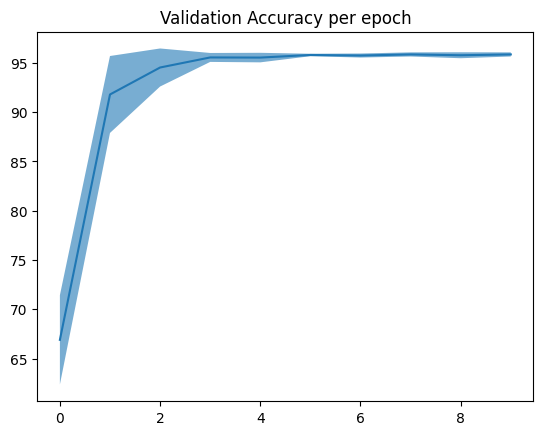

In [9]:
# Mean and std across each each kth fold of validation
train_acc = []
val_acc = []

for i in range(5):
    train_acc.append(train_acc_list[i])
    val_acc.append(val_acc_list[i])

train_acc = np.array(homogenise(train_acc))
val_acc = np.array(homogenise(val_acc))

train_mean = np.mean(train_acc, axis=0)
val_mean = np.mean(val_acc, axis=0)

train_std = np.std(train_acc, axis=0)
val_std = np.std(val_acc, axis=0)

plt.plot(train_mean)
plt.fill_between(range(len(train_mean)),train_mean-train_std,train_mean+train_std,alpha=.6)
plt.title("Training Accuracy per epoch")
plt.savefig("train_acc.png")
plt.close()

plt.plot(val_mean)
plt.fill_between(range(len(val_mean)),val_mean-val_std,val_mean+val_std,alpha=.6)
plt.title("Validation Accuracy per epoch")
plt.savefig("val_acc.png")

print("Training accuracy (last epoch)")
for i in range(5):
    print("K-fold", i, ":", train_acc[i][-1])
print("---------------------------------")
print("Validation accuracy (last epoch)")
for i in range(5):
    print("K-fold", i, ":", val_acc[i][-1])

In [10]:
# Test dataset
model.eval()
test_loss = 0.0
correct = 0
for input, label in test_loader:
    target = model(input)
    loss = criterion(target, label)
    valid_loss += loss.item()
    correct += (target.round()==label).float().sum().item()
avg_loss = valid_loss/len(test_loader)
accuracy = 100*correct/len(X_test)

print("---------------------")
print("Test Accuracy")
print(accuracy)

---------------------
Test Accuracy
95.75
